## 1 - Introduction: Predicting Used Car Prices¶

**Context**: In the highly competitive used car market, pricing accuracy is critical. Overpricing may result in unsold inventory, while underpricing could lead to reduced profit margins. The ability to predict the correct price for a used car based on its attributes can significantly impact a business's bottom line.

**Objective**: The objective of this project is to develop a machine learning model that accurately predicts the price of used cars based on various attributes, such as make, model, year, mileage, condition, and other relevant features. Accurate price predictions will help car dealers, individual sellers, and online marketplaces optimize pricing strategies, leading to better sales performance and customer satisfaction.

**Evaluation Metric**: The model's performance will be evaluated using the Root Mean Squared Error (RMSE). This metric measures the average magnitude of errors between the predicted and actual car prices, giving higher penalties to larger errors. A lower RMSE indicates a more accurate model.

**Impact**: An effective pricing model will allow stakeholders to set competitive prices that attract buyers while maximizing profit margins. It will also help buyers make informed purchasing decisions by providing fair market value estimates.

**Conclusion**: By leveraging the power of machine learning, this project aims to enhance the accuracy of used car price predictions, benefiting both sellers and buyers in the used car market.

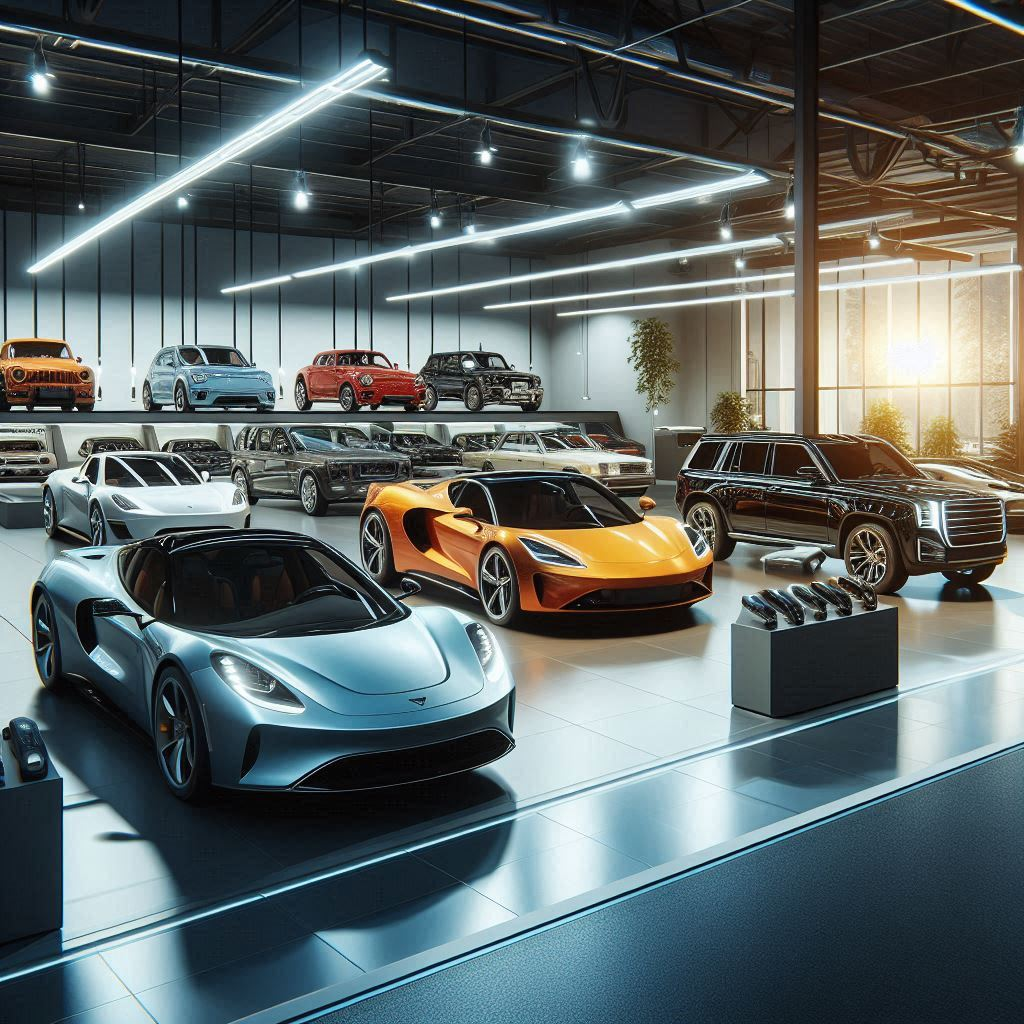

In [77]:
from IPython.display import Image
Image("/kaggle/input/car-showroom/car_showroom.jpeg")

In [79]:
# Import library
import re
import unicodedata
import itertools
import pandas as pd
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import KFold
import gc
import xgboost as xgb
import lightgbm as lgb
from lightgbm import log_evaluation
from catboost import CatBoostRegressor
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
import optuna
sns.set_theme(style='whitegrid')
palette='viridis'
import warnings
warnings.filterwarnings("ignore")

## 2 - Load Data

In [2]:
df = pd.read_csv("/kaggle/input/germany-used-cars-dataset-2023/data.csv")

df.head()

Unnamed: 0       brand              model  color registration_date  year  \
0           0  alfa-romeo     Alfa Romeo GTV    red           10/1995  1995   
1           1  alfa-romeo     Alfa Romeo 164  black           02/1995  1995   
2           2  alfa-romeo  Alfa Romeo Spider  black           02/1995  1995   
3           3  alfa-romeo  Alfa Romeo Spider  black           07/1995  1995   
4           4  alfa-romeo     Alfa Romeo 164    red           11/1996  1996   

  price_in_euro power_kw power_ps transmission_type fuel_type  \
0          1300      148      201            Manual    Petrol   
1         24900      191      260            Manual    Petrol   
2          5900      110      150           Unknown    Petrol   
3          4900      110      150            Manual    Petrol   
4         17950      132      179            Manual    Petrol   

  fuel_consumption_l_100km fuel_consumption_g_km  mileage_in_km  \
0            10,9 l/100 km              260 g/km       160500.0   
1                      NaN              - (g/km)       190000.0   
2                      NaN              - (g/km)       129000.0   
3             9,5 l/100 km              225 g/km       189500.0   
4             7,2 l/100 km              - (g/km)        96127.0   

                       offer_description  
0                              2.0 V6 TB  
1                    Q4 Allrad, 3.2L GTA  
2                          ALFA ROME 916  
3                   2.0 16V Twin Spark L  
4  3.0i Super V6, absoluter Topzustand !

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

In [4]:
df.dtypes

Unnamed: 0                    int64
brand                        object
model                        object
color                        object
registration_date            object
year                         object
price_in_euro                object
power_kw                     object
power_ps                     object
transmission_type            object
fuel_type                    object
fuel_consumption_l_100km     object
fuel_consumption_g_km        object
mileage_in_km               float64
offer_description            object
dtype: object

In [5]:
df.shape

(251079, 15)

## 3 - Data Cleaning

In [6]:
print("Checking for missing values in each column:")
print(df.isnull().sum())

Checking for missing values in each column:
Unnamed: 0                      0
brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    26873
fuel_consumption_g_km           0
mileage_in_km                 152
offer_description               1
dtype: int64


In [7]:
print(df[['color', 'power_kw', 'power_ps','fuel_consumption_l_100km','mileage_in_km']].isnull().sum())

color                         166
power_kw                      134
power_ps                      129
fuel_consumption_l_100km    26873
mileage_in_km                 152
dtype: int64


In [8]:
df = df.drop(['Unnamed: 0','offer_description'], axis=1)
df

brand              model  color registration_date  year  \
0       alfa-romeo     Alfa Romeo GTV    red           10/1995  1995   
1       alfa-romeo     Alfa Romeo 164  black           02/1995  1995   
2       alfa-romeo  Alfa Romeo Spider  black           02/1995  1995   
3       alfa-romeo  Alfa Romeo Spider  black           07/1995  1995   
4       alfa-romeo     Alfa Romeo 164    red           11/1996  1996   
...            ...                ...    ...               ...   ...   
251074       volvo         Volvo XC40  white           04/2023  2023   
251075       volvo         Volvo XC90  white           03/2023  2023   
251076       volvo          Volvo V60  white           05/2023  2023   
251077       volvo         Volvo XC40  white           05/2023  2023   
251078       volvo         Volvo XC40   gold           03/2023  2023   

       price_in_euro power_kw power_ps transmission_type fuel_type  \
0               1300      148      201            Manual    Petrol   
1              24900      191      260            Manual    Petrol   
2               5900      110      150           Unknown    Petrol   
3               4900      110      150            Manual    Petrol   
4              17950      132      179            Manual    Petrol   
...              ...      ...      ...               ...       ...   
251074         57990      192      261         Automatic    Hybrid   
251075         89690      173      235         Automatic    Diesel   
251076         61521      145      197         Automatic    Diesel   
251077         57890      132      179         Automatic    Hybrid   
251078         52900      160      218         Automatic  Electric   

       fuel_consumption_l_100km fuel_consumption_g_km  mileage_in_km  
0                 10,9 l/100 km              260 g/km       160500.0  
1                           NaN              - (g/km)       190000.0  
2                           NaN              - (g/km)       129000.0  
3                  9,5 l/100 km              225 g/km       189500.0  
4                  7,2 l/100 km              - (g/km)        96127.0  
...                         ...                   ...            ...  
251074                      NaN      43 km Reichweite         1229.0  
251075             7,6 l/100 km              202 g/km         4900.0  
251076             4,7 l/100 km              125 g/km         1531.0  
251077                      NaN      45 km Reichweite         1500.0  
251078                      NaN     438 km Reichweite           50.0  

[251079 rows x 13 columns]

The fuel consumption columns are strings which can be converted to integer by removing the "l/100 km" and "g/km".

In [9]:
def clean_columns(df, columns):
    """
    Clean specified columns in a dataframe by removing non-numeric characters
    and converting to appropriate numeric types (float or int).

    Parameters:
    df (pd.DataFrame): The dataframe containing the columns to clean.
    columns (list): A list of column names to clean.

    Returns:
    pd.DataFrame: The dataframe with cleaned columns.
    """
    for col in columns:
        if df[col].str.contains(',').any():
            df[col] = df[col].str.replace(r'[^0-9,]', '', regex=True) 
            df[col] = df[col].str.replace(',', '.').replace('', np.nan) 
            df[col] = df[col].astype(float)
        else:
            df[col] = df[col].str.replace(r'[^0-9]', '', regex=True).replace('', np.nan)  
            df[col] = df[col].astype(float) 
    
    return df

In [10]:
df = clean_columns(df, ['fuel_consumption_l_100km', 'fuel_consumption_g_km'])

In [11]:
print("Checking for missing values in each column:")
print(df.isnull().sum())

Checking for missing values in each column:
brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    26922
fuel_consumption_g_km       36770
mileage_in_km                 152
dtype: int64


In [12]:
df.shape

(251079, 13)

We have lot of missing value in the *fuel_consumption_l_100km* and *fuel_consumption_g_km* after removing the string part from these columns. The fuel_consumption_g_km is a CO₂ emissions (g/km), The column "fuel_consumption_l_100km" value can be calculated using the value from "fuel_consumption_g_km" and by using the type of fuel used in the vehicle which gives the Co2 Factor.

Here is the formula to calculate "*fuel_consumption_l_100km*" and "*fuel_consumption_g_km*".


$ \text{Fuel consumption (g/km)} = \left( \frac{ \text{Fuel consumption (l/100 km)} \times \text{Fuel-specific CO₂ factor (g/l)} }{100} \right)$


$\text{Fuel consumption (l/100 km)} = \left( \frac{ \text{Fuel consumption (g/km)} \times 100 }{ \text{Fuel-specific CO₂ factor (g/l)} } \right)$


In [13]:
CO2_FACTORS = {
    'Petrol': 2350,       
    'Diesel': 2640,        
    'LPG': 1500,           
    'CNG': 1200,           
    'Electric': 0,         
    'Hydrogen': 0          
}

# Function to calculate fuel consumption l/100 km from g/km
def calculate_fuel_consumption_l_100km(row):
    co2_emissions_g_per_km = row['fuel_consumption_g_km']
    fuel_type = row['fuel_type']
    co2_factor = CO2_FACTORS.get(fuel_type, np.nan)
    

    if co2_factor is None or co2_factor == 0:
        return 0 
    
    return (co2_emissions_g_per_km * 100) / co2_factor

# Function to calculate CO₂ emissions g/km from fuel consumption l/100 km
def calculate_fuel_consumption_g_km(row):
    fuel_consumption_l_100km = row['fuel_consumption_l_100km']
    fuel_type = row['fuel_type']
    co2_factor = CO2_FACTORS.get(fuel_type, np.nan)
    
    if co2_factor is None or co2_factor == 0 or fuel_consumption_l_100km is None:
        return np.nan 
    
    return (fuel_consumption_l_100km * co2_factor) / 100


df['fuel_consumption_l_100km'] = df.apply(
    lambda row: calculate_fuel_consumption_l_100km(row) if np.isnan(row['fuel_consumption_l_100km']) else row['fuel_consumption_l_100km'],
    axis=1
)

df['fuel_consumption_g_km'] = df.apply(
    lambda row: calculate_fuel_consumption_g_km(row) if np.isnan(row['fuel_consumption_g_km']) else row['fuel_consumption_g_km'],
    axis=1
)

In [14]:
df.shape

(251079, 13)

In [15]:
df.head()

brand              model  color registration_date  year price_in_euro  \
0  alfa-romeo     Alfa Romeo GTV    red           10/1995  1995          1300   
1  alfa-romeo     Alfa Romeo 164  black           02/1995  1995         24900   
2  alfa-romeo  Alfa Romeo Spider  black           02/1995  1995          5900   
3  alfa-romeo  Alfa Romeo Spider  black           07/1995  1995          4900   
4  alfa-romeo     Alfa Romeo 164    red           11/1996  1996         17950   

  power_kw power_ps transmission_type fuel_type  fuel_consumption_l_100km  \
0      148      201            Manual    Petrol                     10.91   
1      191      260            Manual    Petrol                       NaN   
2      110      150           Unknown    Petrol                       NaN   
3      110      150            Manual    Petrol                      9.51   
4      132      179            Manual    Petrol                      7.21   

   fuel_consumption_g_km  mileage_in_km  
0                260.000       160500.0  
1                    NaN       190000.0  
2                    NaN       129000.0  
3                225.000       189500.0  
4                169.435        96127.0

In [16]:
print("Checking for missing values in each column:")
print(df.isnull().sum())

Checking for missing values in each column:
brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    15694
fuel_consumption_g_km       14511
mileage_in_km                 152
dtype: int64


We were able to fill up around 50% of missing values in the *fuel_consumption_l_100km* and the *fuel_consumption_g_km* using the above technique. We can remove the remaining rows with NA value as there is no other way to fill it up.

In [17]:
def remove_outliers(df, columns, min_rows=10):
    """
    Removes outliers from the specified numeric columns using the IQR method,
    ensuring that at least `min_rows` remain in the DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame from which outliers will be removed.
    columns (list): A list of column names where outliers should be removed.
    min_rows (int): The minimum number of rows that should remain in the DataFrame 
                    after removing outliers. Default is 10.
    
    Returns:
    DataFrame: A DataFrame with outliers removed from the specified columns.
    """
    
    mask = pd.Series(True, index=df.index)
    
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df[col].fillna(df[col].median(), inplace=True)
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)
        
    if mask.sum() >= min_rows:
        df = df[mask]
    else:
        print(f"Unable to apply outlier filter without removing all rows.")
    
    return df

numeric_columns = ['price_in_euro', 'power_kw', 'power_ps', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km']
df = remove_outliers(df, numeric_columns)

print(df.head())


        brand              model  color registration_date  year  \
1  alfa-romeo     Alfa Romeo 164  black           02/1995  1995   
2  alfa-romeo  Alfa Romeo Spider  black           02/1995  1995   
3  alfa-romeo  Alfa Romeo Spider  black           07/1995  1995   
4  alfa-romeo     Alfa Romeo 164    red           11/1996  1996   
5  alfa-romeo  Alfa Romeo Spider    red           04/1996  1996   

   price_in_euro  power_kw  power_ps transmission_type fuel_type  \
1        24900.0     191.0     260.0            Manual    Petrol   
2         5900.0     110.0     150.0           Unknown    Petrol   
3         4900.0     110.0     150.0            Manual    Petrol   
4        17950.0     132.0     179.0            Manual    Petrol   
5         7900.0     110.0     150.0            Manual    Petrol   

   fuel_consumption_l_100km  fuel_consumption_g_km  mileage_in_km  
1                      5.81                137.000       190000.0  
2                      5.81                137.000  

In [18]:
df.shape

(184734, 13)

In [19]:
df.shape

(184734, 13)

In [20]:
def drop_missing(df, columns):
    """Remove rows that contain missing values in the specified columns."""
    
    df = df.dropna(subset=columns)
    
    return df

columns_to_check = ['color', 'registration_date', 'power_kw', 'power_ps', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km']

df = drop_missing(df, columns_to_check)

In [21]:
print("Checking for missing values in each column:")
print(df.isnull().sum())

Checking for missing values in each column:
brand                       0
model                       0
color                       0
registration_date           0
year                        0
price_in_euro               0
power_kw                    0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
fuel_consumption_g_km       0
mileage_in_km               0
dtype: int64


In [22]:
df.shape

(184610, 13)

## 4 - Exploratory Data Analysis

### 4.1 - Feature Types

In [23]:
categorical_features = df.select_dtypes(include='object').columns.tolist()

numerical_features = df.select_dtypes(exclude='object').columns.tolist()

for feature in ['price', 'id']:
    if feature in numerical_features:
        numerical_features.remove(feature)

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

df_numerical

Numerical Variables
0             price_in_euro
1                  power_kw
2                  power_ps
3  fuel_consumption_l_100km
4     fuel_consumption_g_km
5             mileage_in_km

In [24]:
df_categorical

Categorical Variables
0                 brand
1                 model
2                 color
3     registration_date
4                  year
5     transmission_type
6             fuel_type

### 4.2 - Vehicle's Price Trends

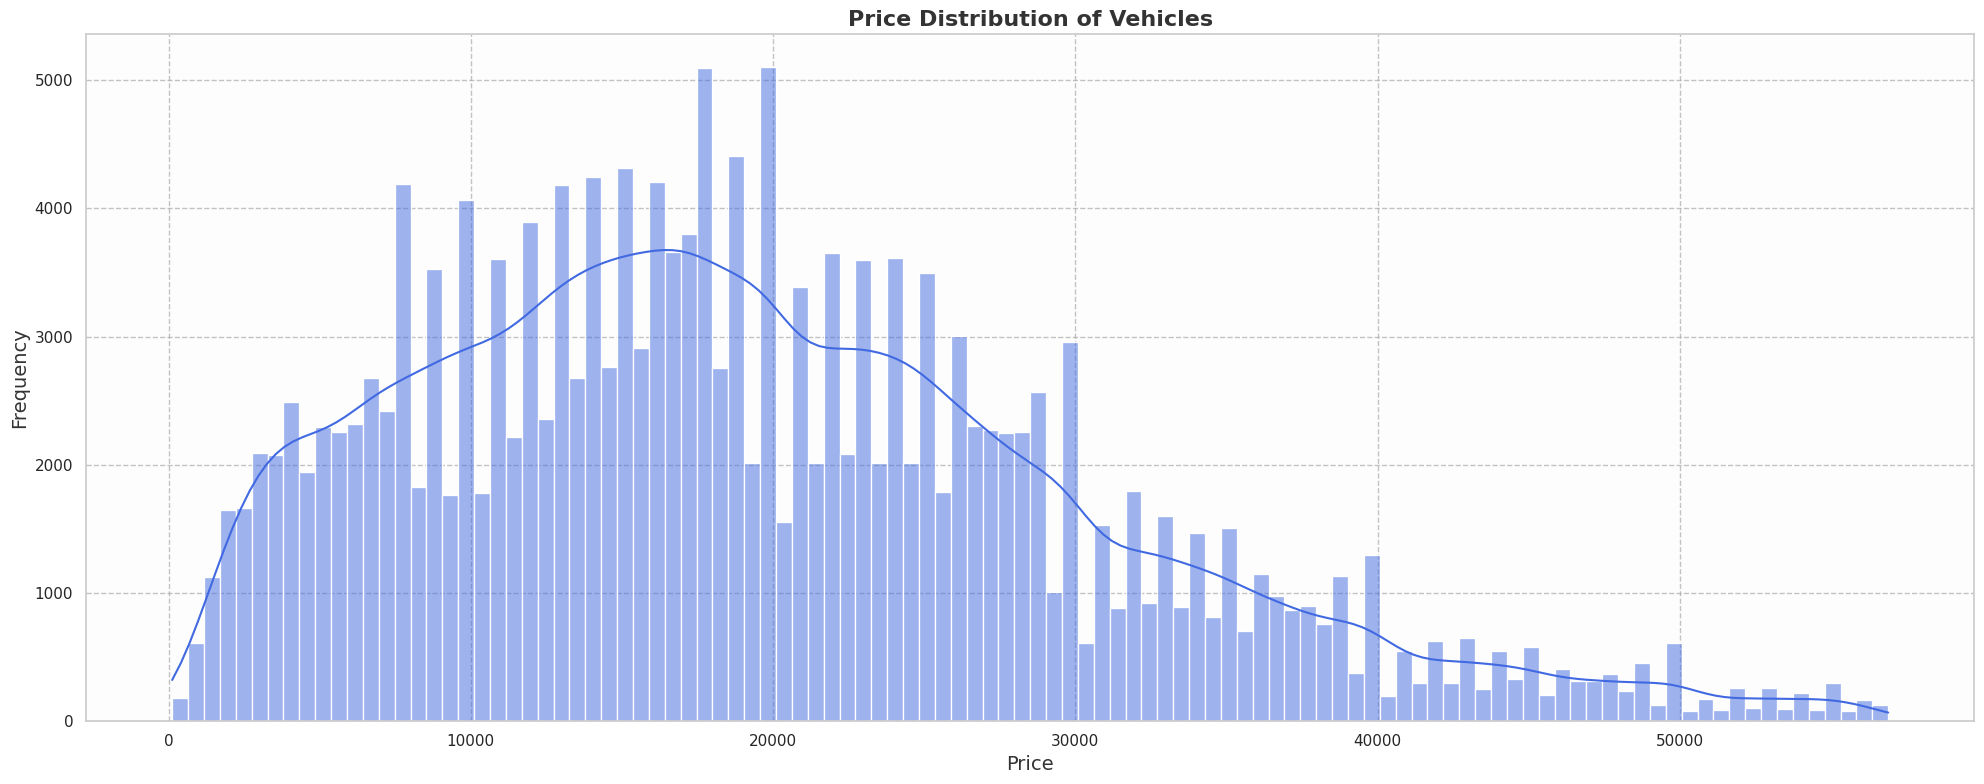

In [25]:
plt.figure(figsize=(20, 8))

hist_color = '#4169E1'  
background_color = '#F5F5F5'  
grid_color = '#A9A9A9' 
text_color = '#333333'  
sns.set(style="whitegrid")

sns.histplot(df['price_in_euro'], kde=True, color=hist_color)
plt.title('Price Distribution of Vehicles', fontsize=16, fontweight='bold', color=text_color)
plt.xlabel('Price', fontsize=14, color=text_color)
plt.ylabel('Frequency', fontsize=14, color=text_color)
plt.gca().patch.set_facecolor(background_color)  
plt.gca().patch.set_alpha(0.1) 
plt.grid(True, linestyle='--', alpha=0.7, color=grid_color) 
plt.tight_layout()
plt.show()

### 4.3 - Fuel type distribution

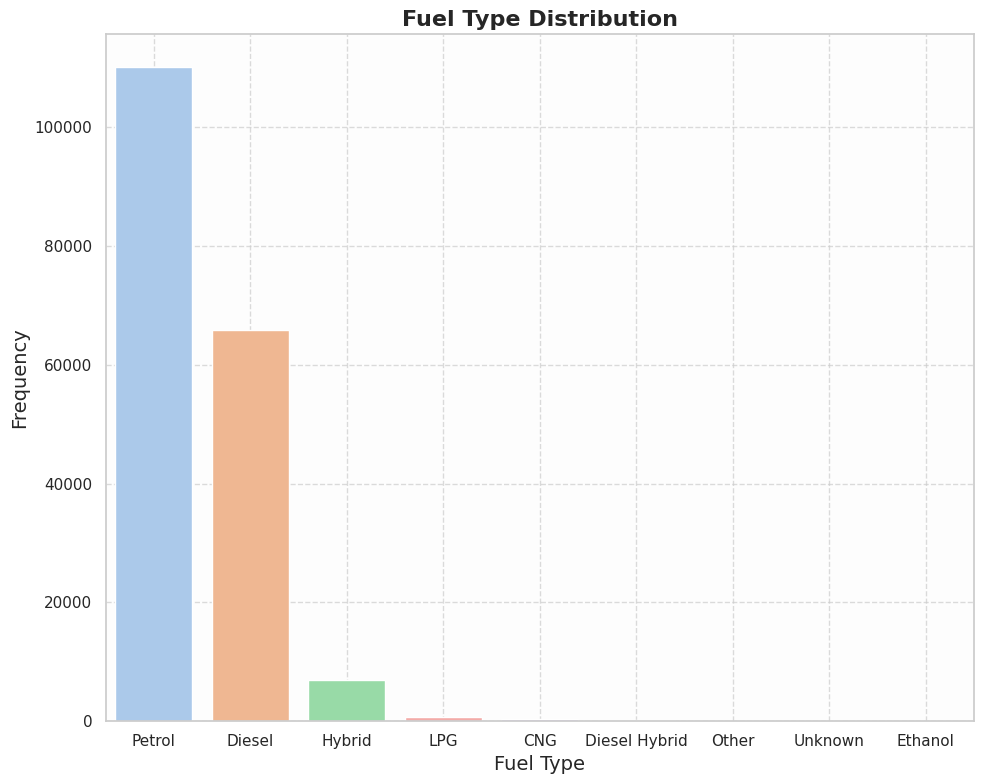

In [26]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8)) 
color_palette = sns.color_palette("pastel")

sns.countplot(data=df, x='fuel_type', order=df['fuel_type'].value_counts().index, palette=color_palette)
plt.title('Fuel Type Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Fuel Type', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.gca().patch.set_facecolor('#F5F5F5')  
plt.gca().patch.set_alpha(0.1)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4.4 - Transmission Type of the car

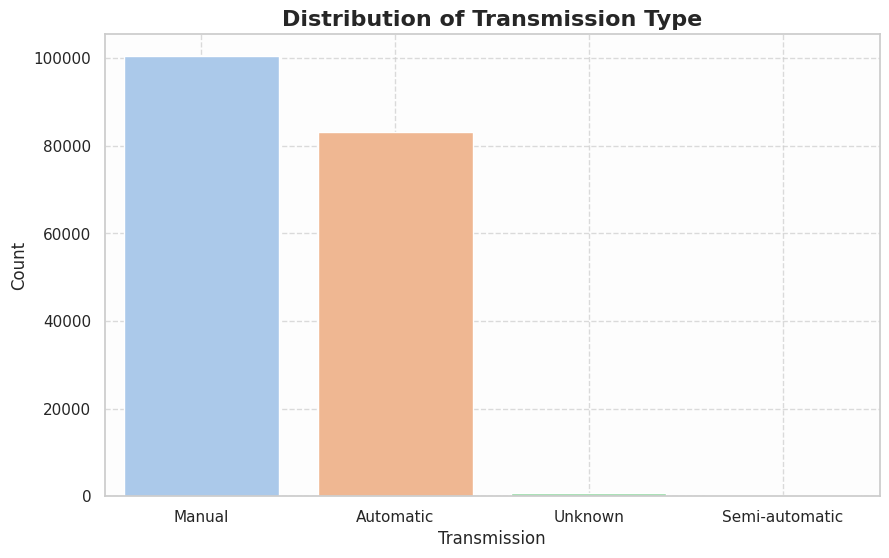

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(x='transmission_type', data=df,order=df['transmission_type'].value_counts().index, palette = color_palette)
plt.title('Distribution of Transmission Type', fontsize=16, fontweight='bold')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.gca().patch.set_facecolor('#F5F5F5')
plt.gca().patch.set_alpha(0.1) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 4.5 - Distribution of Car Brands

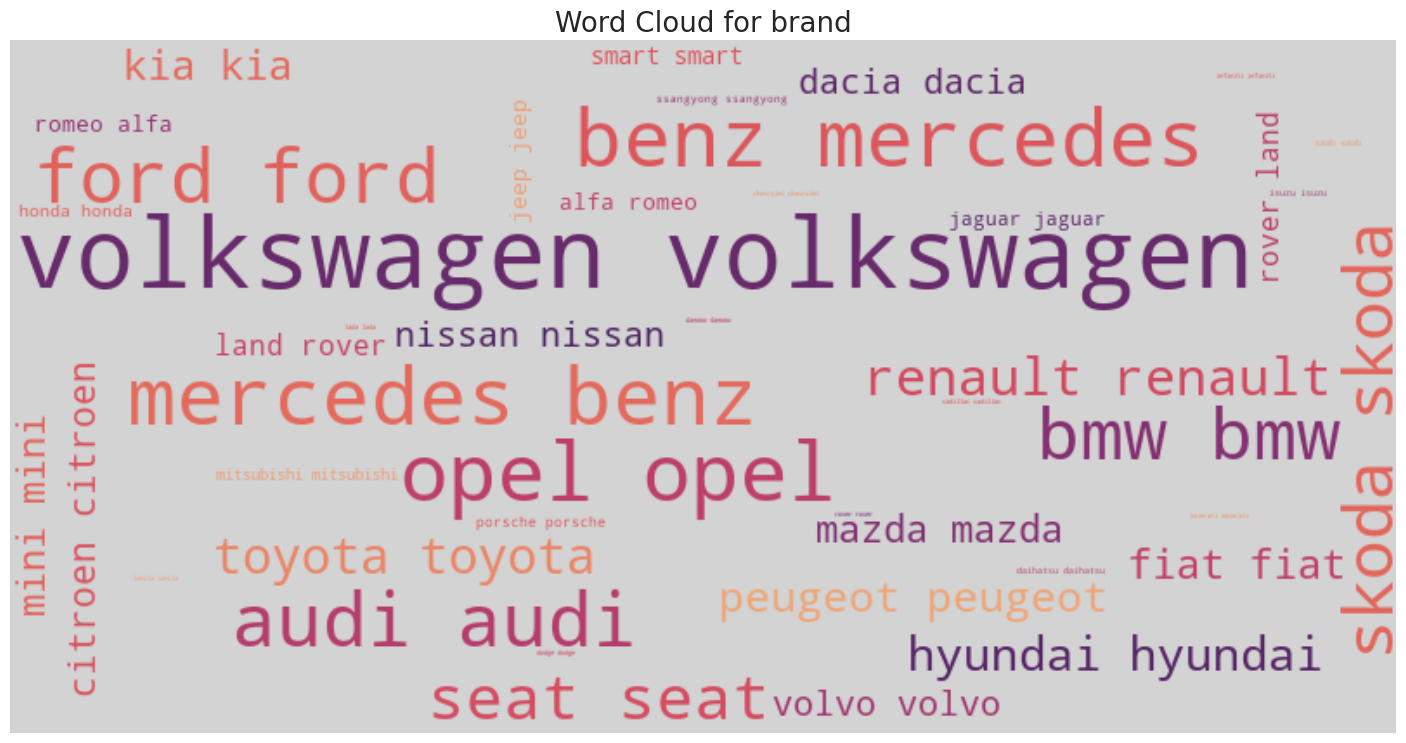

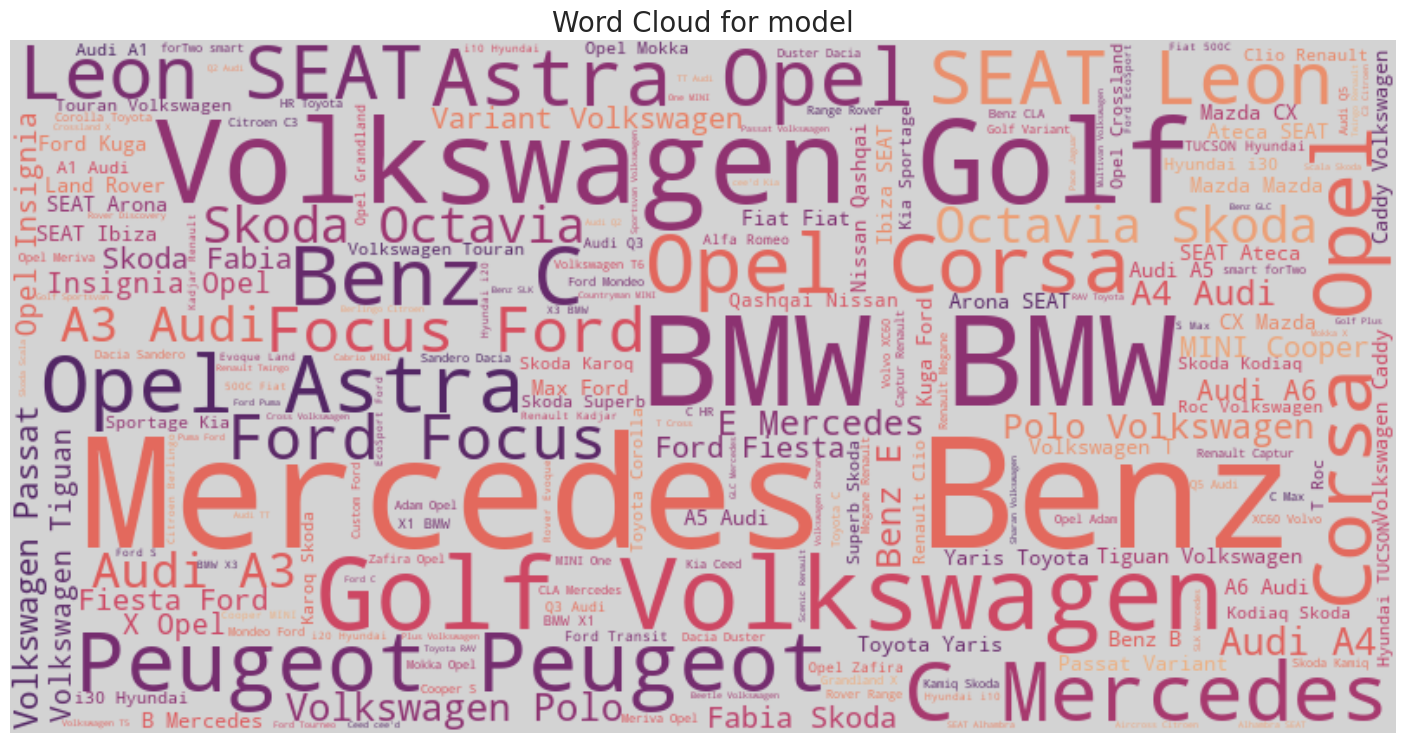

In [28]:
cat_features_word = ['brand', 'model']
palettes = 'flare'

for feature in cat_features_word:
    text = ' '.join(df[feature].astype(str).values)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='lightgray',
        colormap = palettes).generate(text)
    
    plt.figure(figsize=(20, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {feature}', fontsize=20)
    plt.subplots_adjust(hspace=3) 
    plt.show()

### 4.6 - Distribution of Car Colors 

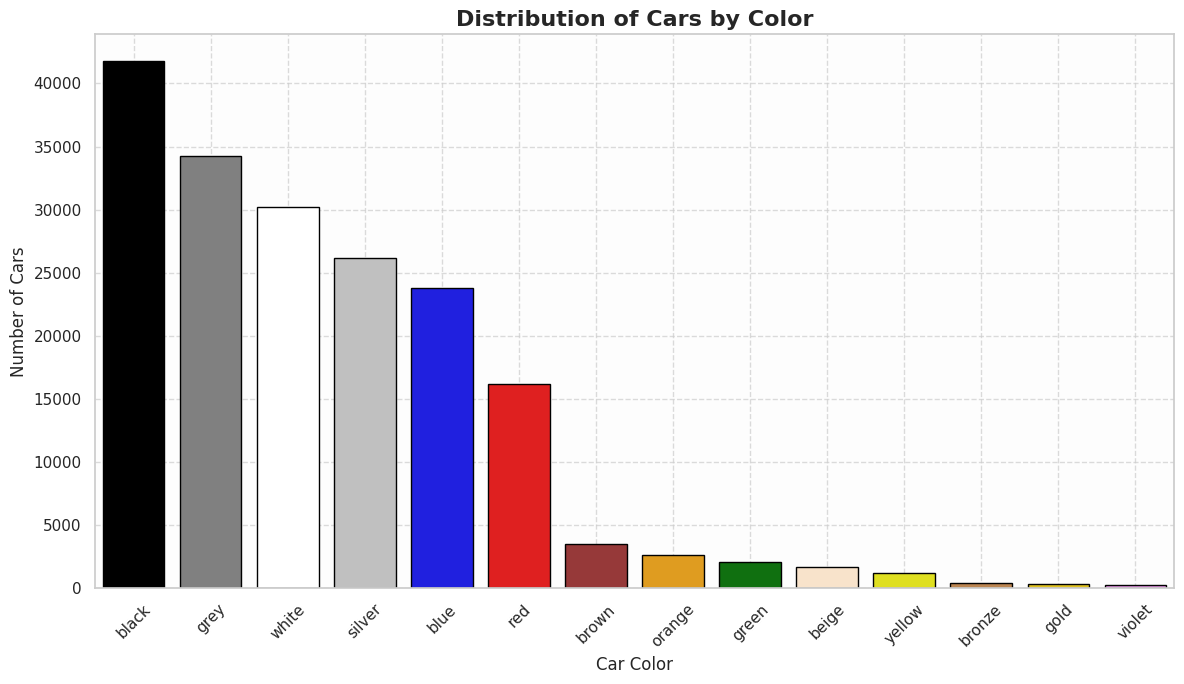

In [29]:
color_palette = {
    'black': 'black',
    'grey': 'grey',
    'white': 'white',  
    'silver': 'silver',
    'blue': 'blue',
    'red': 'red',
    'brown': 'brown',
    'orange': 'orange',
    'green': 'green',
    'beige': 'bisque',  
    'yellow': 'yellow',
    'bronze': 'peru',   
    'gold': 'gold',
    'violet': 'violet'
}

sorted_colors = df['color'].value_counts().index
palette = {color: color_palette.get(color, 'grey') for color in sorted_colors}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))  
bars = sns.countplot(x='color', data=df, order=sorted_colors, palette=palette, edgecolor='black')

plt.title('Distribution of Cars by Color', fontsize=16, fontweight='bold')
plt.xlabel('Car Color', fontsize=12)
plt.ylabel('Number of Cars', fontsize=12)
plt.gca().patch.set_facecolor('#F5F5F5')
plt.gca().patch.set_alpha(0.1)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.7 - Correlation of Numeric values

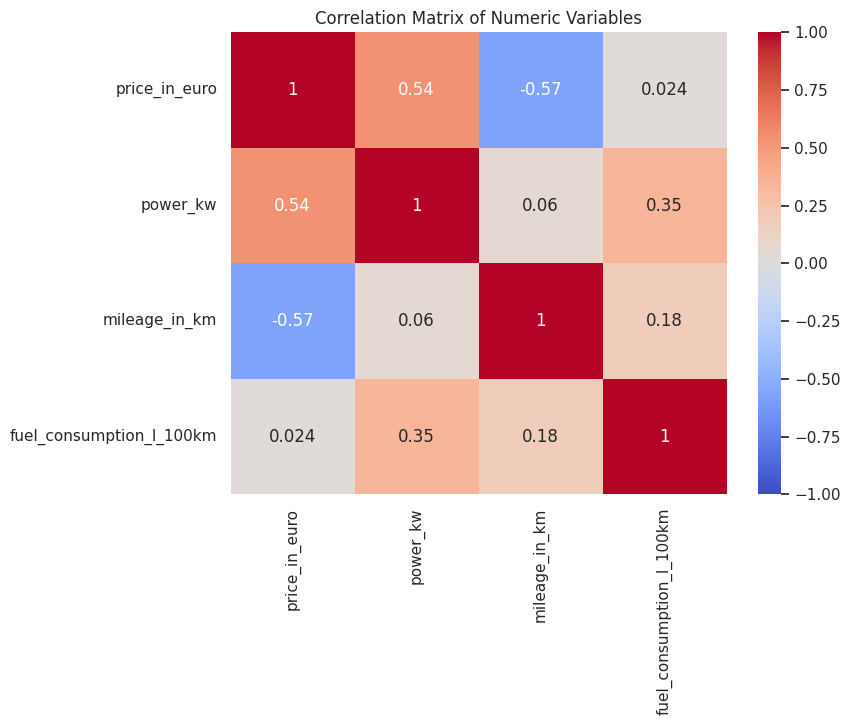

In [30]:
numeric_cols = ['price_in_euro', 'power_kw', 'mileage_in_km', 'fuel_consumption_l_100km']
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

### 4.8 - Fuel Consumption, Price and Power trend based on Registration Year

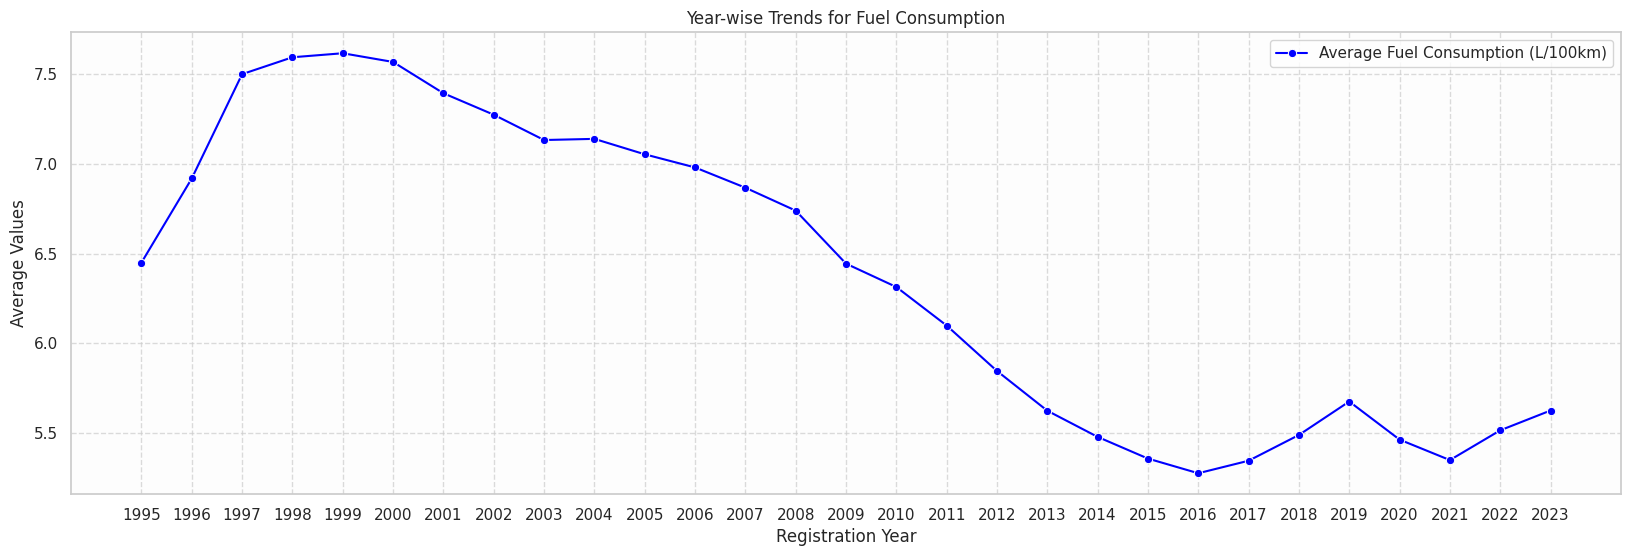

In [31]:
yearly_data = df.groupby('year').agg({
    'price_in_euro': 'mean',
    'power_kw': 'mean',
    'fuel_consumption_l_100km': 'mean'
}).reset_index()

plt.figure(figsize=(20, 6))

sns.lineplot(x='year', y='fuel_consumption_l_100km', data=yearly_data, label='Average Fuel Consumption (L/100km)', marker='o',color='blue')
plt.title('Year-wise Trends for Fuel Consumption')
plt.xlabel('Registration Year')
plt.ylabel('Average Values')
plt.gca().patch.set_facecolor('#F5F5F5')  
plt.gca().patch.set_alpha(0.1)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()

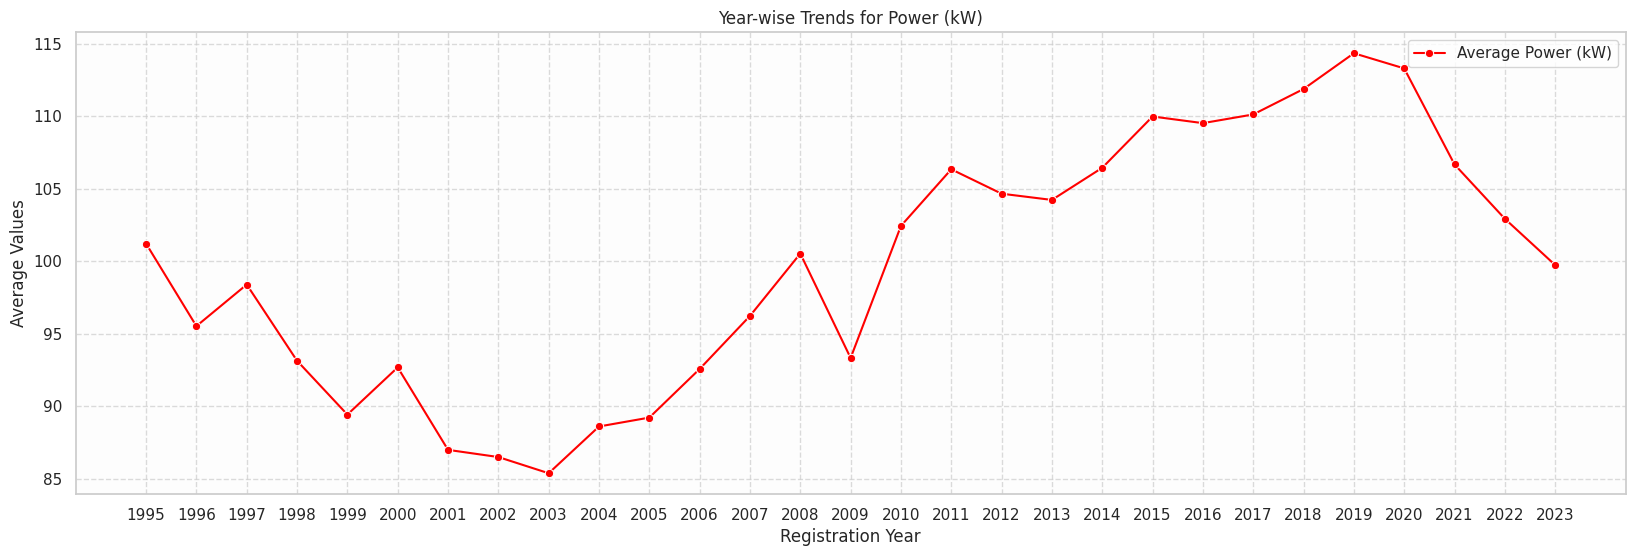

In [32]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='year', y='power_kw', data=yearly_data, label='Average Power (kW)', marker='o', color='red')
plt.title('Year-wise Trends for Power (kW)')
plt.xlabel('Registration Year')
plt.ylabel('Average Values')
plt.gca().patch.set_facecolor('#F5F5F5') 
plt.gca().patch.set_alpha(0.1) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()

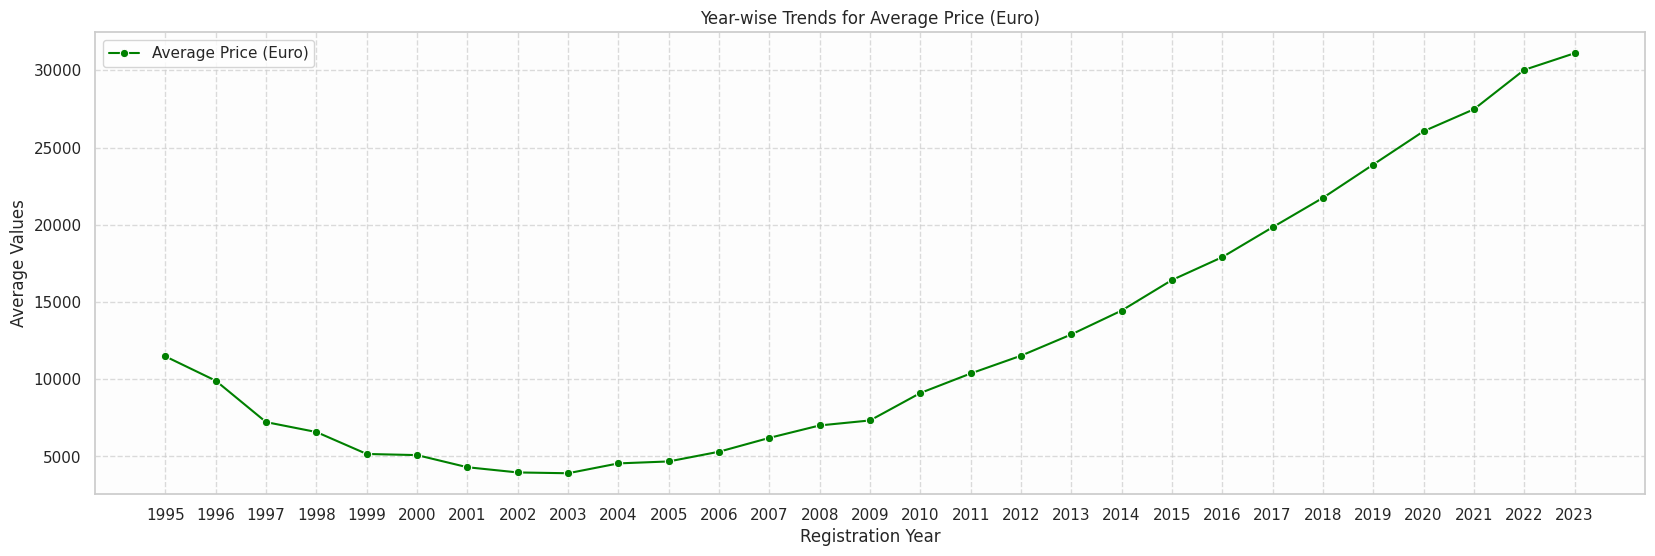

In [33]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='year', y='price_in_euro', data=yearly_data, label='Average Price (Euro)', marker='o',color='green')
plt.title('Year-wise Trends for Average Price (Euro)')
plt.xlabel('Registration Year')
plt.ylabel('Average Values')
plt.gca().patch.set_facecolor('#F5F5F5') 
plt.gca().patch.set_alpha(0.1)  

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()

### 4.9 - Fuel Type Vs Fuel Efficency

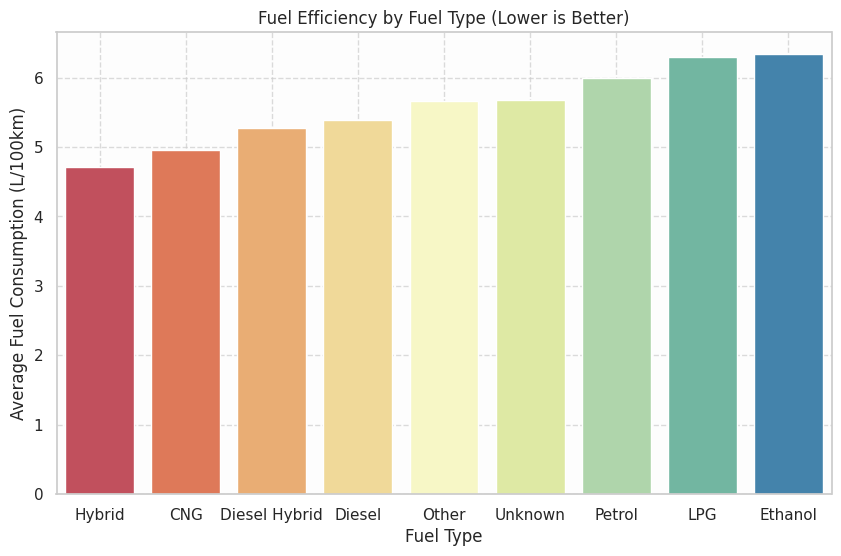

In [34]:

fuel_efficiency = df.groupby('fuel_type')['fuel_consumption_l_100km'].mean().reset_index()
fuel_efficiency = fuel_efficiency.sort_values(by='fuel_consumption_l_100km')
plt.figure(figsize=(10, 6))
sns.barplot(x='fuel_type', y='fuel_consumption_l_100km', data=fuel_efficiency, palette='Spectral')
plt.title('Fuel Efficiency by Fuel Type (Lower is Better)')
plt.xlabel('Fuel Type')
plt.ylabel('Average Fuel Consumption (L/100km)')
plt.gca().patch.set_facecolor('#F5F5F5')
plt.gca().patch.set_alpha(0.1) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## 5 - Feature Engineering

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184610 entries, 1 to 251073
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     184610 non-null  object 
 1   model                     184610 non-null  object 
 2   color                     184610 non-null  object 
 3   registration_date         184610 non-null  object 
 4   year                      184610 non-null  object 
 5   price_in_euro             184610 non-null  float64
 6   power_kw                  184610 non-null  float64
 7   power_ps                  184610 non-null  float64
 8   transmission_type         184610 non-null  object 
 9   fuel_type                 184610 non-null  object 
 10  fuel_consumption_l_100km  184610 non-null  float64
 11  fuel_consumption_g_km     184610 non-null  float64
 12  mileage_in_km             184610 non-null  float64
dtypes: float64(6), object(7)
memory usage: 19.7+ MB


In [36]:
df['year'] = df['year'].astype(int)

In [37]:
df.head()

brand              model  color registration_date  year  \
1  alfa-romeo     Alfa Romeo 164  black           02/1995  1995   
2  alfa-romeo  Alfa Romeo Spider  black           02/1995  1995   
3  alfa-romeo  Alfa Romeo Spider  black           07/1995  1995   
4  alfa-romeo     Alfa Romeo 164    red           11/1996  1996   
5  alfa-romeo  Alfa Romeo Spider    red           04/1996  1996   

   price_in_euro  power_kw  power_ps transmission_type fuel_type  \
1        24900.0     191.0     260.0            Manual    Petrol   
2         5900.0     110.0     150.0           Unknown    Petrol   
3         4900.0     110.0     150.0            Manual    Petrol   
4        17950.0     132.0     179.0            Manual    Petrol   
5         7900.0     110.0     150.0            Manual    Petrol   

   fuel_consumption_l_100km  fuel_consumption_g_km  mileage_in_km  
1                      5.81                137.000       190000.0  
2                      5.81                137.000       129000.0  
3                      9.51                225.000       189500.0  
4                      7.21                169.435        96127.0  
5                      9.51                225.000        47307.0

As we also have the year column which provide the information about car model's year. We can drop the 'registration_date' . 

In [39]:
df = df.drop(['registration_date'], axis=1)

In [40]:
df.head()

brand              model  color  year  price_in_euro  power_kw  \
1  alfa-romeo     Alfa Romeo 164  black  1995        24900.0     191.0   
2  alfa-romeo  Alfa Romeo Spider  black  1995         5900.0     110.0   
3  alfa-romeo  Alfa Romeo Spider  black  1995         4900.0     110.0   
4  alfa-romeo     Alfa Romeo 164    red  1996        17950.0     132.0   
5  alfa-romeo  Alfa Romeo Spider    red  1996         7900.0     110.0   

   power_ps transmission_type fuel_type  fuel_consumption_l_100km  \
1     260.0            Manual    Petrol                      5.81   
2     150.0           Unknown    Petrol                      5.81   
3     150.0            Manual    Petrol                      9.51   
4     179.0            Manual    Petrol                      7.21   
5     150.0            Manual    Petrol                      9.51   

   fuel_consumption_g_km  mileage_in_km  
1                137.000       190000.0  
2                137.000       129000.0  
3                225.000       189500.0  
4                169.435        96127.0  
5                225.000        47307.0

In [41]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

encoder = ce.BinaryEncoder(cols=['brand', 'model', 'color', 'transmission_type', 'fuel_type'])
df_encoded = encoder.fit_transform(df)


scaler = StandardScaler()
numeric_cols = ['year', 'power_kw', 'power_ps', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km']
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

## 6 -  Training and testing data division

In [42]:
df_encoded.head()

brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  model_0  model_1  \
1        0        0        0        0        0        1        0        0   
2        0        0        0        0        0        1        0        0   
3        0        0        0        0        0        1        0        0   
4        0        0        0        0        0        1        0        0   
5        0        0        0        0        0        1        0        0   

   model_2  model_3  ...  transmission_type_0  transmission_type_1  \
1        0        0  ...                    0                    0   
2        0        0  ...                    0                    1   
3        0        0  ...                    0                    0   
4        0        0  ...                    0                    0   
5        0        0  ...                    0                    0   

   transmission_type_2  fuel_type_0  fuel_type_1  fuel_type_2  fuel_type_3  \
1                    1            0            0            0            1   
2                    0            0            0            0            1   
3                    1            0            0            0            1   
4                    1            0            0            0            1   
5                    1            0            0            0            1   

   fuel_consumption_l_100km  fuel_consumption_g_km  mileage_in_km  
1                  0.076244              -0.046565       1.570205  
2                  0.076244              -0.046565       0.661128  
3                  3.257795               3.041359       1.562754  
4                  1.280074               1.091581       0.171225  
5                  3.257795               3.041359      -0.556334  

[5 rows x 34 columns]

In [43]:
X = df_encoded.drop('price_in_euro', axis=1)
y = df_encoded['price_in_euro']

In [44]:
X.shape

(184610, 33)

In [45]:
X.columns

Index(['brand_0', 'brand_1', 'brand_2', 'brand_3', 'brand_4', 'brand_5',
       'model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5',
       'model_6', 'model_7', 'model_8', 'model_9', 'color_0', 'color_1',
       'color_2', 'color_3', 'year', 'power_kw', 'power_ps',
       'transmission_type_0', 'transmission_type_1', 'transmission_type_2',
       'fuel_type_0', 'fuel_type_1', 'fuel_type_2', 'fuel_type_3',
       'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km'],
      dtype='object')

## 7 -  Model training

Here I am dividing the data to 80/20 split of training and testing sets.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print("Viewing X train data:", X_train.shape)

print("Viewing y train data:", y_train.shape)

Viewing X train data: (147688, 33)
Viewing y train data: (147688,)


In [49]:
X_train.head()

brand_0  brand_1  brand_2  brand_3  brand_4  brand_5  model_0  \
62940         0        0        1        1        0        1        0   
3767          0        0        0        0        1        0        0   
208988        1        0        1        0        0        0        1   
37463         0        0        0        0        1        1        0   
213705        1        0        1        0        0        1        1   

        model_1  model_2  model_3  ...  transmission_type_0  \
62940         0        1        1  ...                    0   
3767          0        0        0  ...                    0   
208988        1        0        0  ...                    0   
37463         0        0        0  ...                    0   
213705        1        0        1  ...                    0   

        transmission_type_1  transmission_type_2  fuel_type_0  fuel_type_1  \
62940                     0                    1            0            0   
3767                      1                    1            0            0   
208988                    1                    1            0            0   
37463                     1                    1            0            0   
213705                    0                    1            0            0   

        fuel_type_2  fuel_type_3  fuel_consumption_l_100km  \
62940             0            1                 -0.783635   
3767              1            0                  1.366062   
208988            1            1                 -1.127586   
37463             1            0                 -0.353696   
213705            0            1                  0.076244   

        fuel_consumption_g_km  mileage_in_km  
62940               -0.993996       0.756924  
3767                 1.953568       1.823554  
208988              -1.344896      -0.528123  
37463                0.023615       0.203416  
213705              -0.046565       1.048604  

[5 rows x 33 columns]

### 7.1 - Base Models

In [54]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              early_stopping_rounds=10, 
              verbose=True)

xgb_model_pred = xgb_model.predict(X_test)


lgbm_model = lgb.LGBMRegressor()
lgbm_model.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],  
               callbacks=[log_evaluation(10)])


lgbm_predictions = lgbm_model.predict(X_test)


catboost_model = CatBoostRegressor()
catboost_model.fit(X_train, y_train, 
                   eval_set=(X_test, y_test), 
                   early_stopping_rounds=10)


catboost_predictions = catboost_model.predict(X_test)


lgbm_rmse = sqrt(mean_squared_error(y_test, lgbm_predictions))
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_model_pred))
catboost_rmse = sqrt(mean_squared_error(y_test, catboost_predictions))

print(f"Base LightGBM RMSE: {lgbm_rmse:.4f}")
print(f"Base XGBoost RMSE: {xgb_rmse:.4f}")
print(f"Base CatBoost RMSE: {catboost_rmse:.4f}")

[0]	validation_0-rmse:8706.41349
[1]	validation_0-rmse:7071.75508
[2]	validation_0-rmse:6013.57562
[3]	validation_0-rmse:5360.81588
[4]	validation_0-rmse:4920.82588
[5]	validation_0-rmse:4620.89553
[6]	validation_0-rmse:4434.16351
[7]	validation_0-rmse:4315.20808
[8]	validation_0-rmse:4197.28975
[9]	validation_0-rmse:4123.41376
[10]	validation_0-rmse:4060.11484
[11]	validation_0-rmse:4030.00778
[12]	validation_0-rmse:4001.70474
[13]	validation_0-rmse:3975.21847
[14]	validation_0-rmse:3947.33757
[15]	validation_0-rmse:3928.30120
[16]	validation_0-rmse:3913.13935
[17]	validation_0-rmse:3907.00471
[18]	validation_0-rmse:3897.78122
[19]	validation_0-rmse:3876.64379
[20]	validation_0-rmse:3869.65306
[21]	validation_0-rmse:3853.96690
[22]	validation_0-rmse:3848.02087
[23]	validation_0-rmse:3838.58053
[24]	validation_0-rmse:3819.96479
[25]	validation_0-rmse:3806.89223
[26]	validation_0-rmse:3796.23678
[27]	validation_0-rmse:3792.30335
[28]	validation_0-rmse:3788.77846
[29]	validation_0-rmse:3

In [55]:
print(f"Base LightGBM RMSE: {lgbm_rmse:.4f}")
print(f"Base XGBoost RMSE: {xgb_rmse:.4f}")
print(f"Base CatBoost RMSE: {catboost_rmse:.4f}")

Base LightGBM RMSE: 3659.4487
Base XGBoost RMSE: 3519.9040
Base CatBoost RMSE: 3447.5232


### 7.2 - Hyper-Parameter tuning

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def log_trial_results(trial, model_name, params, train_rmse, val_rmse):
    print(f"Trial: {trial.number}, Model: {model_name}, "
          f"Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, "
          f"Params: {params}")


def objective_xgb(trial):
    xgb_params = {
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'early_stopping_rounds': 10
    }
    
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose = 0)
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    
    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_test, val_preds))


    return val_rmse


def objective_lgb(trial):
    lgbm_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'early_stopping_rounds': 10,
        
    }
    
    model = LGBMRegressor(**lgbm_params, verbosity = -1)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)] )
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_test, val_preds))


    return val_rmse


def objective_cat(trial):
    catboost_params = {
        'iterations': trial.suggest_int('iterations', 500, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'loss_function': 'RMSE',
        'task_type': 'GPU',
        'early_stopping_rounds': 10
    }
    
    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test),verbose= False)
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_test, val_preds))


    return val_rmse


study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=150)


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=150)


study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=150)


print("Best hyperparameters for XGBoost:", study_xgb.best_params)
print("\n Best hyperparameters for LightGBM:", study_lgb.best_params)
print("\n Best hyperparameters for CatBoost:", study_cat.best_params)


### 7.3 - Training with best hyperparameters

In [53]:
xgb_params = {
    'tree_method': 'gpu_hist',              
    'predictor': 'gpu_predictor',           
    'objective': 'reg:squarederror',       
    'n_estimators': 1350,                   
    'learning_rate': 0.015071094502202675,  
    'max_depth': 10,                        
    'subsample': 0.8185835097600456,        
    'colsample_bytree': 0.5129375290017316, 
    'reg_alpha': 0.7954099230393975,      
    'reg_lambda': 0.7979536825864483,        
}

lgbm_params = {
    'boosting_type': 'gbdt',             
    'objective': 'regression',          
    'metric': 'rmse',                   
    'device': 'gpu',                     
    'gpu_platform_id': 0,              
    'gpu_device_id': 0,                 
    'learning_rate': 0.09460463447713698, 
    'num_leaves': 294, 
    'max_depth': 14, 
    'min_child_samples': 13, 
    'subsample': 0.9185205187596595, 
    'colsample_bytree': 0.651524885119411, 
    'reg_alpha': 0.23037764227550753, 
    'reg_lambda': 0.31063723579244723,
}

catboost_params = {
    
    'iterations': 1374,                          
    'learning_rate': 0.025159611688430866,        
    'depth': 15,                                   
    'l2_leaf_reg': 0.5341791384764665,            
    'bagging_temperature': 0.6819137718294943,  
    'random_strength': 0.9904349371367444,        
    'border_count': 221, 
    'min_data_in_leaf': 47, 
    'grow_policy': 'SymmetricTree',
    'eval_metric': 'RMSE',               
    'task_type': 'GPU',                 
}

xgb.set_config(verbosity=0)

xgb_model_hp = XGBRegressor(**xgb_params)
xgb_model_hp.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              early_stopping_rounds=10)

xgb_hp_pred = xgb_model_hp.predict(X_test)

lgbm_model_hp = LGBMRegressor(**lgbm_params,verbosity = -1)
lgbm_model_hp.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],  
               callbacks=[log_evaluation(10)])

lgbm_hp_pred = lgbm_model_hp.predict(X_test)

catboost_model_hp = CatBoostRegressor(**catboost_params)
catboost_model_hp.fit(X_train, y_train, 
                   eval_set=(X_test, y_test), 
                   early_stopping_rounds=10, verbose = False)

catboost_hp_pred = catboost_model_hp.predict(X_test)

lgbm_rmse_hp = sqrt(mean_squared_error(y_test, lgbm_hp_pred))
xgb_rmse_hp = sqrt(mean_squared_error(y_test, xgb_hp_pred))
catboost_rmse_hp = sqrt(mean_squared_error(y_test, catboost_hp_pred))

print(f"LightGBM BEST RMSE: {lgbm_rmse_hp:.4f}")
print(f"XGBoost BEST RMSE: {xgb_rmse_hp:.4f}")
print(f"CatBoost BEST RMSE: {catboost_rmse_hp:.4f}")


[0]	validation_0-rmse:11093.09728
[1]	validation_0-rmse:10982.58318
[2]	validation_0-rmse:10864.58167
[3]	validation_0-rmse:10735.02543
[4]	validation_0-rmse:10601.07333
[5]	validation_0-rmse:10469.79977
[6]	validation_0-rmse:10396.46811
[7]	validation_0-rmse:10275.17686
[8]	validation_0-rmse:10158.10388
[9]	validation_0-rmse:10064.37285
[10]	validation_0-rmse:9964.44308
[11]	validation_0-rmse:9875.34070
[12]	validation_0-rmse:9754.38460
[13]	validation_0-rmse:9668.22834
[14]	validation_0-rmse:9551.95898
[15]	validation_0-rmse:9459.00901
[16]	validation_0-rmse:9349.99917
[17]	validation_0-rmse:9240.03111
[18]	validation_0-rmse:9163.62042
[19]	validation_0-rmse:9086.36050
[20]	validation_0-rmse:8980.02716
[21]	validation_0-rmse:8923.69266
[22]	validation_0-rmse:8849.33612
[23]	validation_0-rmse:8745.71943
[24]	validation_0-rmse:8644.42972
[25]	validation_0-rmse:8549.97771
[26]	validation_0-rmse:8455.85579
[27]	validation_0-rmse:8359.93814
[28]	validation_0-rmse:8280.60852
[29]	validatio

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[10]	valid_0's rmse: 5788.48
[20]	valid_0's rmse: 4111.49
[30]	valid_0's rmse: 3671.47
[40]	valid_0's rmse: 3515.37
[50]	valid_0's rmse: 3436.02
[60]	valid_0's rmse: 3402.66
[70]	valid_0's rmse: 3363.65
[80]	valid_0's rmse: 3339.3
[90]	valid_0's rmse: 3325.99
[100]	valid_0's rmse: 3314.7
LightGBM BEST RMSE: 3314.6998
XGBoost BEST RMSE: 3245.6179
CatBoost BEST RMSE: 3224.0350


In [56]:

print(f"Base LightGBM RMSE: {lgbm_rmse:.4f}  BEST LightGBM  RMSE: {lgbm_rmse_hp:.4f}")
print(f"Base XGBoost RMSE: {xgb_rmse:.4f} BEST XGBoost  RMSE: {xgb_rmse_hp:.4f}")
print(f"Base CatBoost RMSE: {catboost_rmse:.4f} BEST CatBoost  RMSE: {catboost_rmse_hp:.4f}")


Base LightGBM RMSE: 3659.4487  BEST LightGBM  RMSE: 3314.6998
Base XGBoost RMSE: 3519.9040 BEST XGBoost  RMSE: 3245.6179
Base CatBoost RMSE: 3447.5232 BEST CatBoost  RMSE: 3224.0350


The CatBoost model performed better compared to the LightGBM and XGBoost Model.

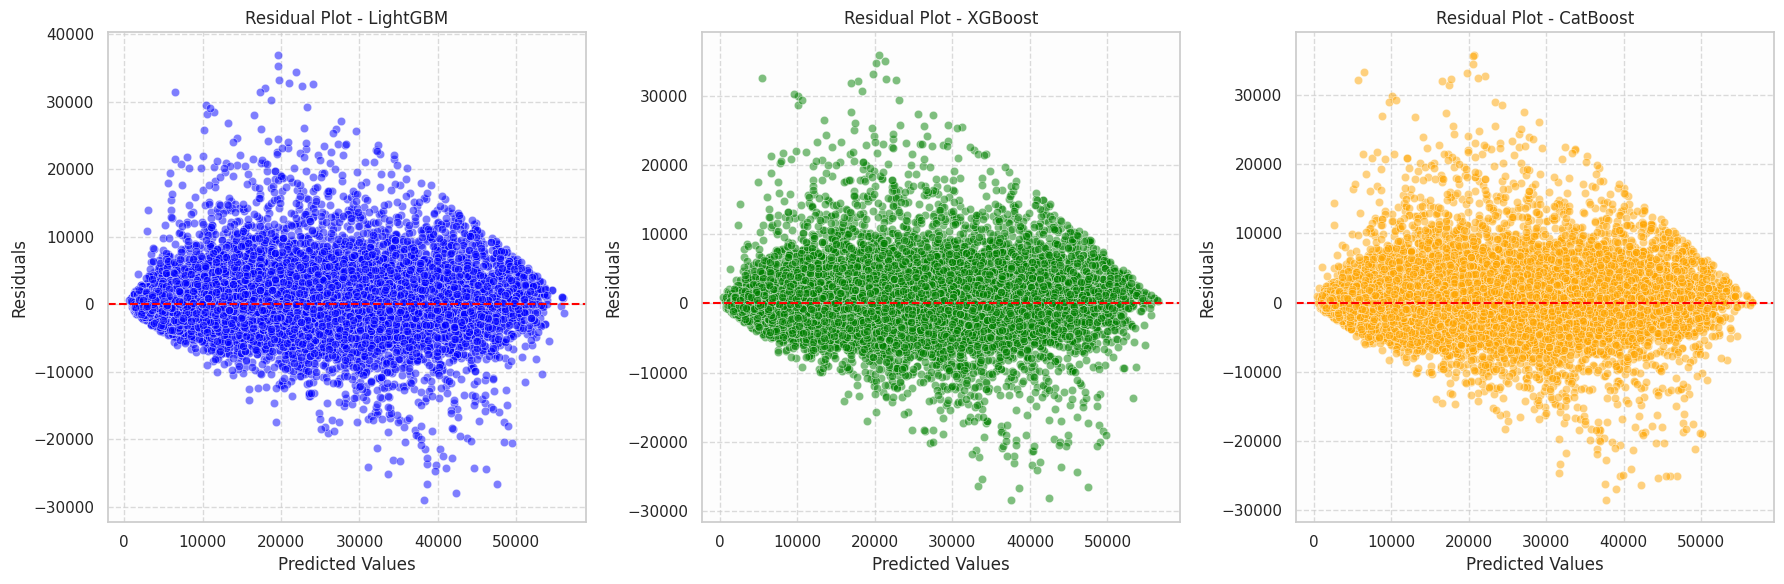

In [73]:
lgbm_residuals = y_test - lgbm_hp_pred
xgb_residuals = y_test - xgb_hp_pred
cat_residuals = y_test - catboost_hp_pred


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1) 
sns.scatterplot(x=lgbm_hp_pred, y=lgbm_residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot - LightGBM')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.gca().patch.set_facecolor('#F5F5F5') 
plt.gca().patch.set_alpha(0.1)  

plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)  
sns.scatterplot(x=xgb_hp_pred, y=xgb_residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot - XGBoost')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.gca().patch.set_facecolor('#F5F5F5')  
plt.gca().patch.set_alpha(0.1)  

plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)  
sns.scatterplot(x=catboost_hp_pred, y=cat_residuals, color='orange', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot - CatBoost')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.gca().patch.set_facecolor('#F5F5F5') 
plt.gca().patch.set_alpha(0.1)  

# Customize grid lines
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

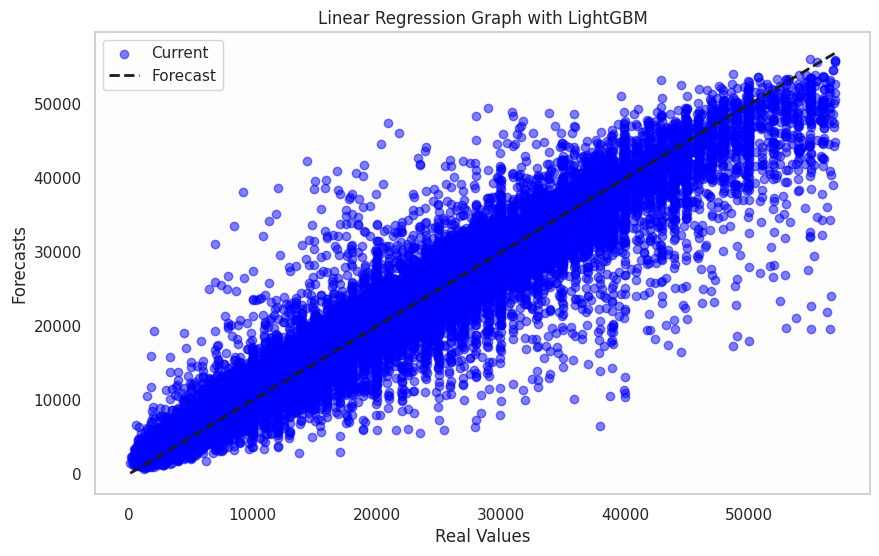

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgbm_hp_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend(["Current", "Forecast"])
plt.xlabel('Real Values')
plt.ylabel('Forecasts')
plt.title('Linear Regression Graph with LightGBM')
plt.grid(False)
plt.show()

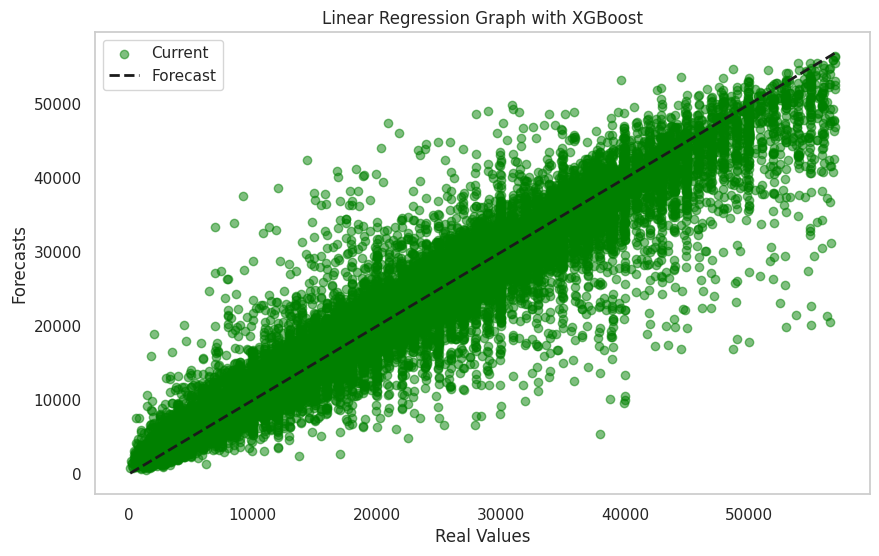

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_hp_pred, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.legend(["Current", "Forecast"])
plt.xlabel('Real Values')
plt.ylabel('Forecasts')
plt.title('Linear Regression Graph with XGBoost')
plt.grid(False)
plt.show()

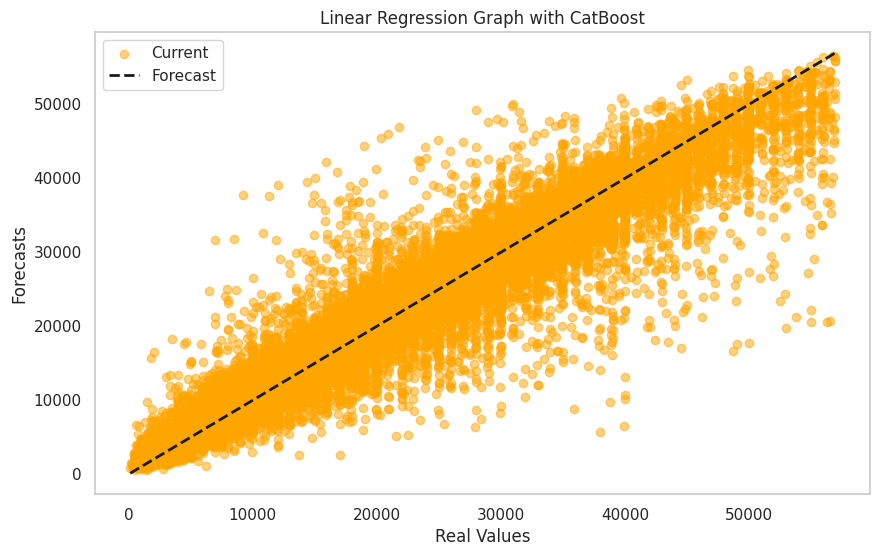

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, catboost_hp_pred, color='orange', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.legend(["Current", "Forecast"])
plt.xlabel('Real Values')
plt.ylabel('Forecasts')
plt.title('Linear Regression Graph with CatBoost')
plt.grid(False)
plt.show()

## 8 - Important Features

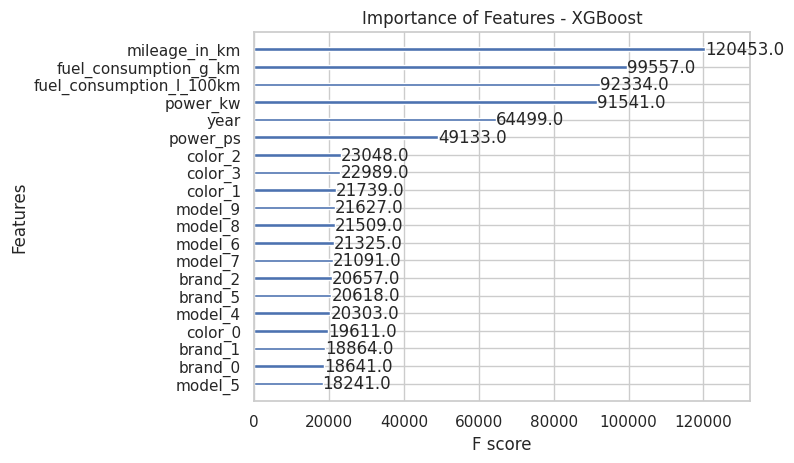

In [61]:
xgb.plot_importance(xgb_model_hp, max_num_features=20, importance_type='weight')
plt.title('Importance of Features - XGBoost')
plt.show()

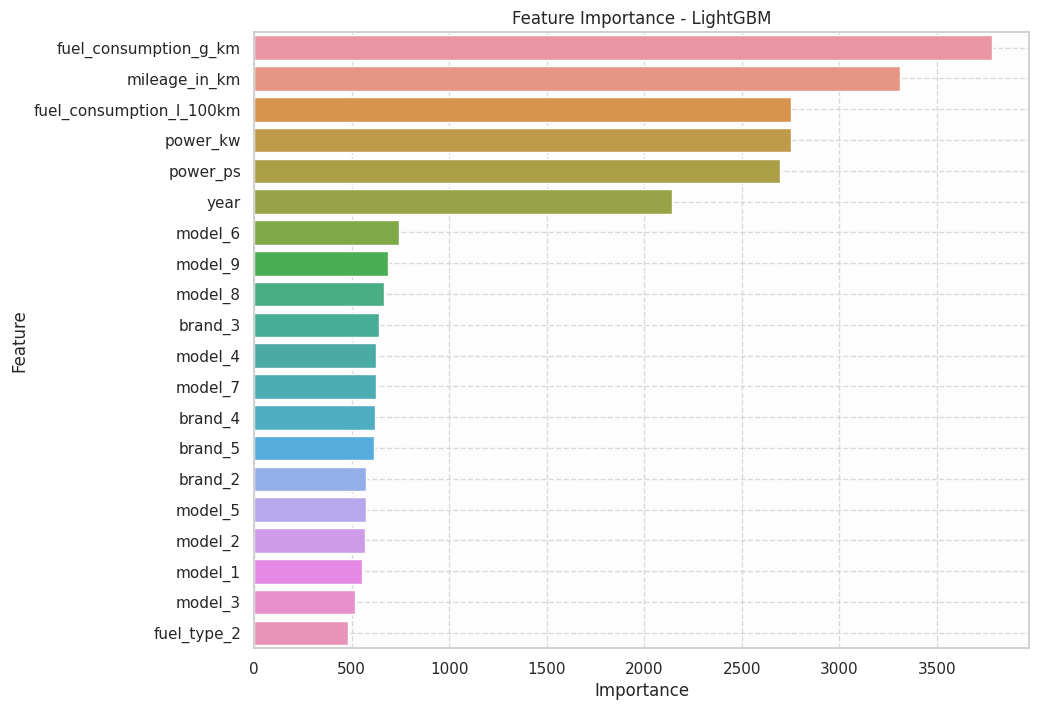

In [75]:
lgbm_feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                         'Importance': lgbm_model_hp.feature_importances_})

lgbm_feature_importances = lgbm_feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=lgbm_feature_importances.head(20))
plt.title('Feature Importance - LightGBM')
plt.gca().patch.set_facecolor('#F5F5F5') 
plt.gca().patch.set_alpha(0.1) 


plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

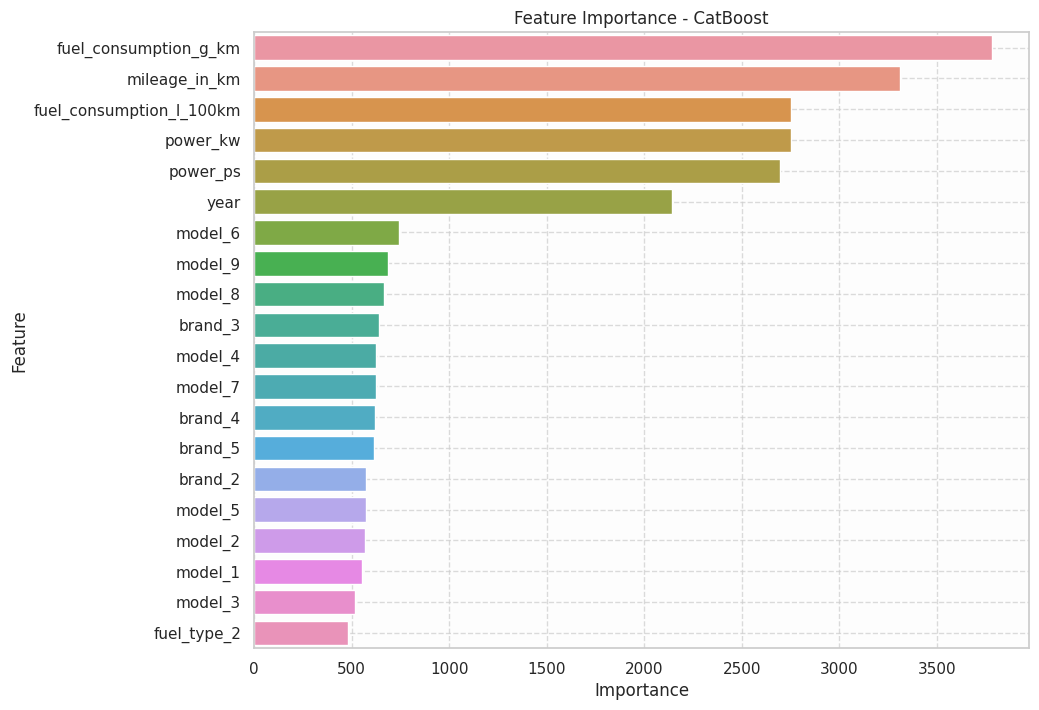

In [76]:
catboost_feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                         'Importance': catboost_model_hp.get_feature_importance()})

catboost_feature_importances = catboost_feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=lgbm_feature_importances.head(20))
plt.title('Feature Importance - CatBoost')
plt.gca().patch.set_facecolor('#F5F5F5')  
plt.gca().patch.set_alpha(0.1) 

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This bar chart displays the feature importance derived from the CatBoost model, highlighting the contribution of each feature to the model's predictive performance.

Key Insights:

**Fuel Consumption and Mileage:** These two features rank highest in importance, indicating they have the greatest influence on car price predictions. This aligns with expectations, as a car's fuel consumption and mileage often strongly affect its resale value.

**Power and Model Year:** These are also significant factors, showing that both the car's power and its age are critical in determining its price.

**Brand and Model:** These features have moderate importance, reflecting how a car's brand and model can influence its price due to perceptions of quality or luxury.

**Conclusion:** Understanding feature importance helps identify the key factors that most impact the car pricing model. This information can guide further model refinement, either by focusing on the most impactful features or improving data collection for less important ones to enhance their predictive strength.

## 9 -  Final result

In [69]:
lgbm_r2 = r2_score(y_test, lgbm_hp_pred)
lgbm_rmse = sqrt(mean_squared_error(y_test, lgbm_hp_pred))

xgb_r2 = r2_score(y_test, xgb_hp_pred)
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_hp_pred))

cat_r2 = r2_score(y_test, catboost_hp_pred)
cat_rmse = sqrt(mean_squared_error(y_test, catboost_hp_pred))

results = {"Model": ["LightGBM", "XGBoost", "CatBoost"],
           "R²": [lgbm_r2, xgb_r2, cat_r2],
           "RMSE": [lgbm_rmse, xgb_rmse, cat_rmse]}

results_df = pd.DataFrame(results)

results_df

Model        R²         RMSE
0  LightGBM  0.912955  3314.699804
1   XGBoost  0.916546  3245.617915
2  CatBoost  0.917652  3224.034970

## Analysis:

##### 1. R² (R-squared) Values:
LightGBM: 0.912955
XGBoost: 0.916546
CatBoost: 0.917652
The R² values for all three models are quite similar, indicating that each explains approximately 91% of the variance in the target variable. This suggests that they are capturing a comparable amount of the underlying patterns in the data.

##### 2. RMSE (Root Mean Squared Error) Values:
LightGBM: 3314.70
XGBoost: 3245.62
CatBoost: 3224.03
The RMSE values, which represent the average difference between the predicted and actual values, are also close. CatBoost has the lowest RMSE, followed closely by XGBoost, indicating that both models offer slightly better predictive accuracy than LightGBM. A lower RMSE implies a better model fit, with CatBoost showing a marginal advantage.

##### Conclusion:
All three models—LightGBM, XGBoost, and CatBoost—perform similarly in terms of predictive power on this dataset, with only minor differences. While CatBoost and XGBoost have a slight edge in RMSE, LightGBM remains highly competitive. The final choice between these models may depend on factors like training speed, ease of interpretation, or the specific requirements of the task, as their overall performance is nearly equivalent.

## Saving Model for Future Use

In [71]:
import pickle

with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(catboost_model_hp, f)

with open('catboost_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [72]:
catboost_model_hp.save_model('catboost_model.cbm')